In [1]:
# for recall clean df (after EDA)
%store -r billboard_df_eda 

## IDEA:
#### Cluster analisys in order to create some **'fictitious users'**

#### so we want to add a column 'users' that will be the users that evaluate the songs (trought the variable valence) 

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

#! pip install plotly_express
import plotly.subplots as sp
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd

## But before we want to obtain a smaller df, that contain only the 'maingenre' with the **highst number of songs**

In [3]:
billboard_df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27901 entries, 0 to 29502
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   index                          27901 non-null  int64  
 1   SongID                         27901 non-null  object 
 2   Performer                      27901 non-null  object 
 3   Song                           27901 non-null  object 
 4   spotify_genre                  27901 non-null  object 
 5   spotify_track_duration_minute  27901 non-null  float64
 6   spotify_track_explicit         27901 non-null  object 
 7   spotify_track_album            27901 non-null  object 
 8   danceability                   27901 non-null  float64
 9   energy                         27901 non-null  float64
 10  key                            27901 non-null  float64
 11  loudness                       27901 non-null  float64
 12  mode                           27901 non-null  floa

In [4]:
#we take the 17 maingenre
numbers_of_genere=billboard_df_eda.maingenere.value_counts()[0:17]
numbers_of_genere
#this is the less present maingenere
worst_genere=billboard_df_eda.maingenere.value_counts()[17:]
worst_genere
#we make a copy of the initial dataframe
top17_genere_df=billboard_df_eda.copy()
top17_genere_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27901 entries, 0 to 29502
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   index                          27901 non-null  int64  
 1   SongID                         27901 non-null  object 
 2   Performer                      27901 non-null  object 
 3   Song                           27901 non-null  object 
 4   spotify_genre                  27901 non-null  object 
 5   spotify_track_duration_minute  27901 non-null  float64
 6   spotify_track_explicit         27901 non-null  object 
 7   spotify_track_album            27901 non-null  object 
 8   danceability                   27901 non-null  float64
 9   energy                         27901 non-null  float64
 10  key                            27901 non-null  float64
 11  loudness                       27901 non-null  float64
 12  mode                           27901 non-null  floa

In [5]:
#we drop all the genres after the 17th
for i in worst_genere.index:
    top17_genere_df=top17_genere_df.drop(top17_genere_df[top17_genere_df.maingenere==i].index)

In [6]:
# we can see that the dimension of the df is smaller (not much), with respect to the billboard_df_eda, since we considered only the 17 maingenre
top17_genere_df.shape

(27319, 22)

In [7]:
billboard_df_eda.shape

(27901, 22)

### We are interested in finding which rows of the dataframe are similar, to put them in different groups: we want **homogeneity within the group** and **heterogeneity between groups**

In [8]:
# first we have to define our variables of interest
column_to_use=['danceability','energy','key','loudness','mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness','valence','time_signature','tempo','spotify_track_duration_minute']
#and define another dataframe with only this variable
cluster_df=top17_genere_df[column_to_use]
cluster_df.head(3)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,time_signature,tempo,spotify_track_duration_minute
0,0.590,0.570,5.37,-9.970,0.75,0.0700,0.400,0.080000,0.200,0.63,3.89,117.760,3.43
1,0.590,0.570,5.37,-9.970,0.75,0.0700,0.400,0.080000,0.200,0.63,3.89,117.760,3.43
2,0.154,0.185,5.00,-14.063,1.00,0.0315,0.911,0.000267,0.112,0.15,4.00,83.969,2.77


In [9]:
top17_genere_df.maingenere.unique()

array(['other', 'pop', 'rock', 'rap', 'indie', 'country', 'soul', 'funk',
       'blues', 'dance', 'disco', 'jazz', 'metal', 'folk', 'r&b', 'house',
       'latin'], dtype=object)

In [10]:
#now we have to standardize the columns of this dataframe, the main reason to do this is to garant that all the varaible have the same scale
#but there are other
cluster_df=(cluster_df-cluster_df.mean()/cluster_df.std())

 ### Cluster Analysis is based  on **distances within observation**, so we have to compute it

In [11]:
# we define an empty list where we store the sum squered of the distance for each number of cluster
ssd=[]
# Fit the KMeans model to the data with a range of different numbers of clusters - assign a center and verify how many cluster minimize the distance
for k in range(1,13):
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(cluster_df)
    ssd.append(kmeans.inertia_)

### ***How to choose how many cluster*** ?
### we have to build a scree plot and look for the 'Elbow point'

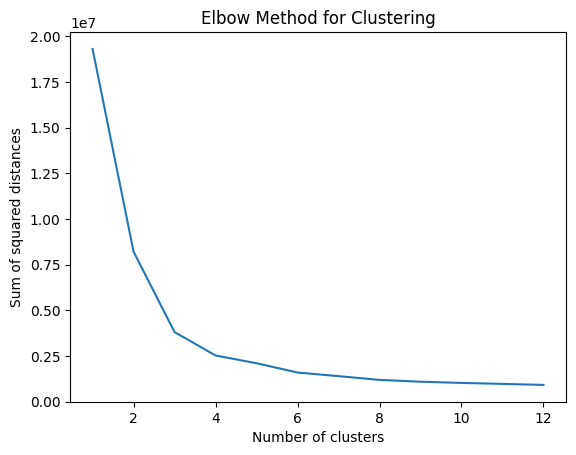

In [12]:
# Elbow point: is the point where the the ssd start to linear increase
plt.plot(range(1,13),ssd)
plt.title('Elbow Method for Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.show()

#### **we can see that our 'Elbow point' is at k=4, so we try to build a model using 4 cluster**

In [13]:
# Starting to build a model
# I decide to select 4 cluster (seeing the elbow point), moreover using 5 or 6 but gives bad results
kmeans=KMeans(n_clusters=4,random_state=1)
kmeans.fit(cluster_df)

KMeans(n_clusters=4, random_state=1)

In [14]:
#To generate the clusters with the KMeans algorithm, we can use the predict() method on the fitted KMeans model
clusters=kmeans.predict(cluster_df)
#print(clusters[:10])

### How to evalute if the model that we have built is a good model ?

**Silhouette method: is an index that move from -1 to 1**, provides a measure of how similar an object is to the cluster it belongs to compared to other clusters

In [15]:
silhouette_score(cluster_df,clusters)

np.float64(0.42350955616274394)

## To visualize the Clusters

In [16]:
#to visualize the cluster we need to reduce the data to two dimension, we have to use PCA (principal component analysis)
# the aim is to lost less information as possible, reduction the dimansion of the data
pca=PCA(n_components=2)
df_2d=pca.fit_transform(cluster_df)

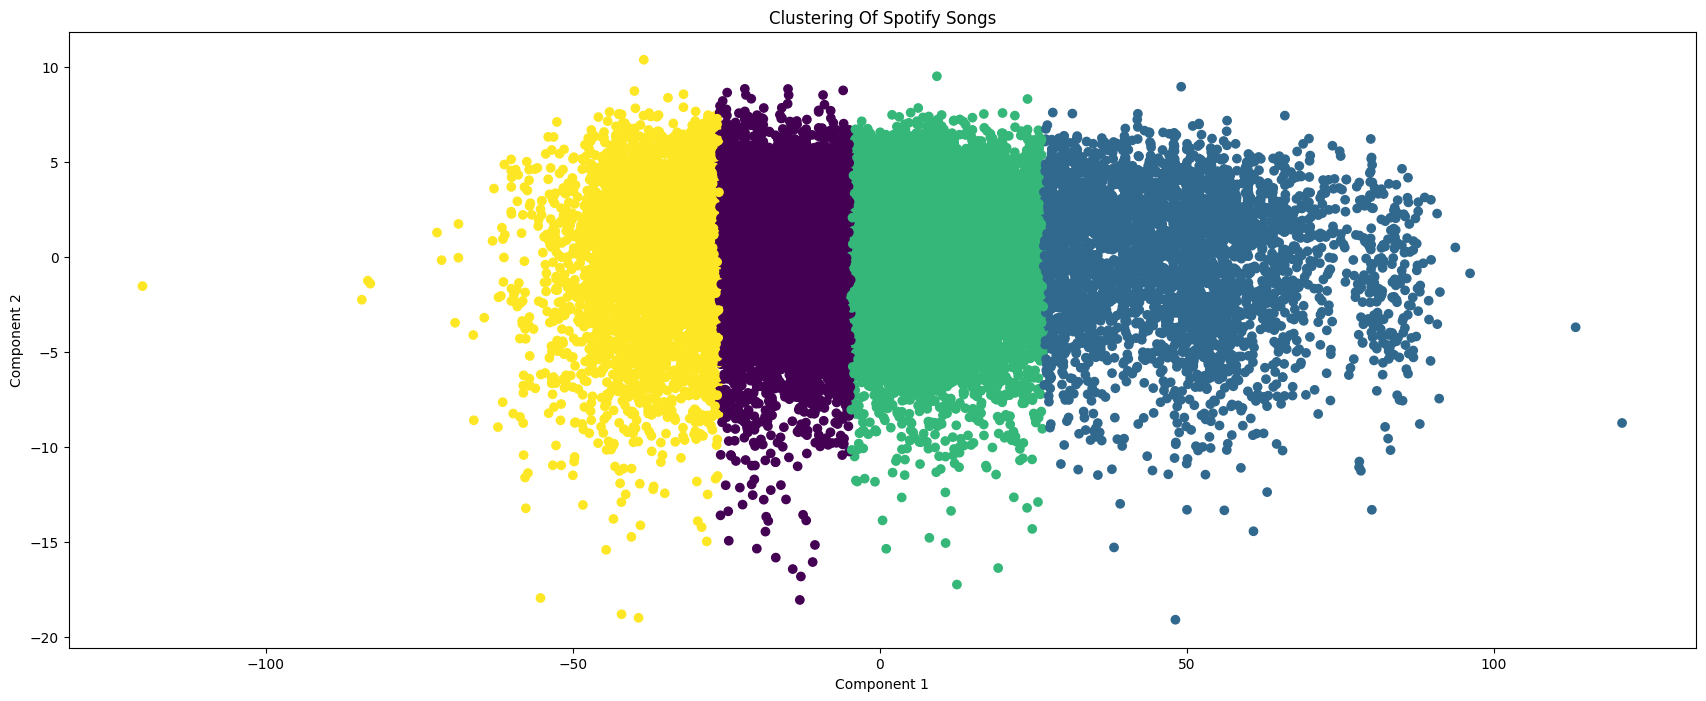

In [17]:
plt.figure(figsize=(21,8))
plt.scatter(df_2d[:, 0], df_2d[:, 1], c=clusters)
plt.title('Clustering Of Spotify Songs')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

### We can notice that we have **4 clear groups**

#### We build a subplot where we want to look for the single cluster

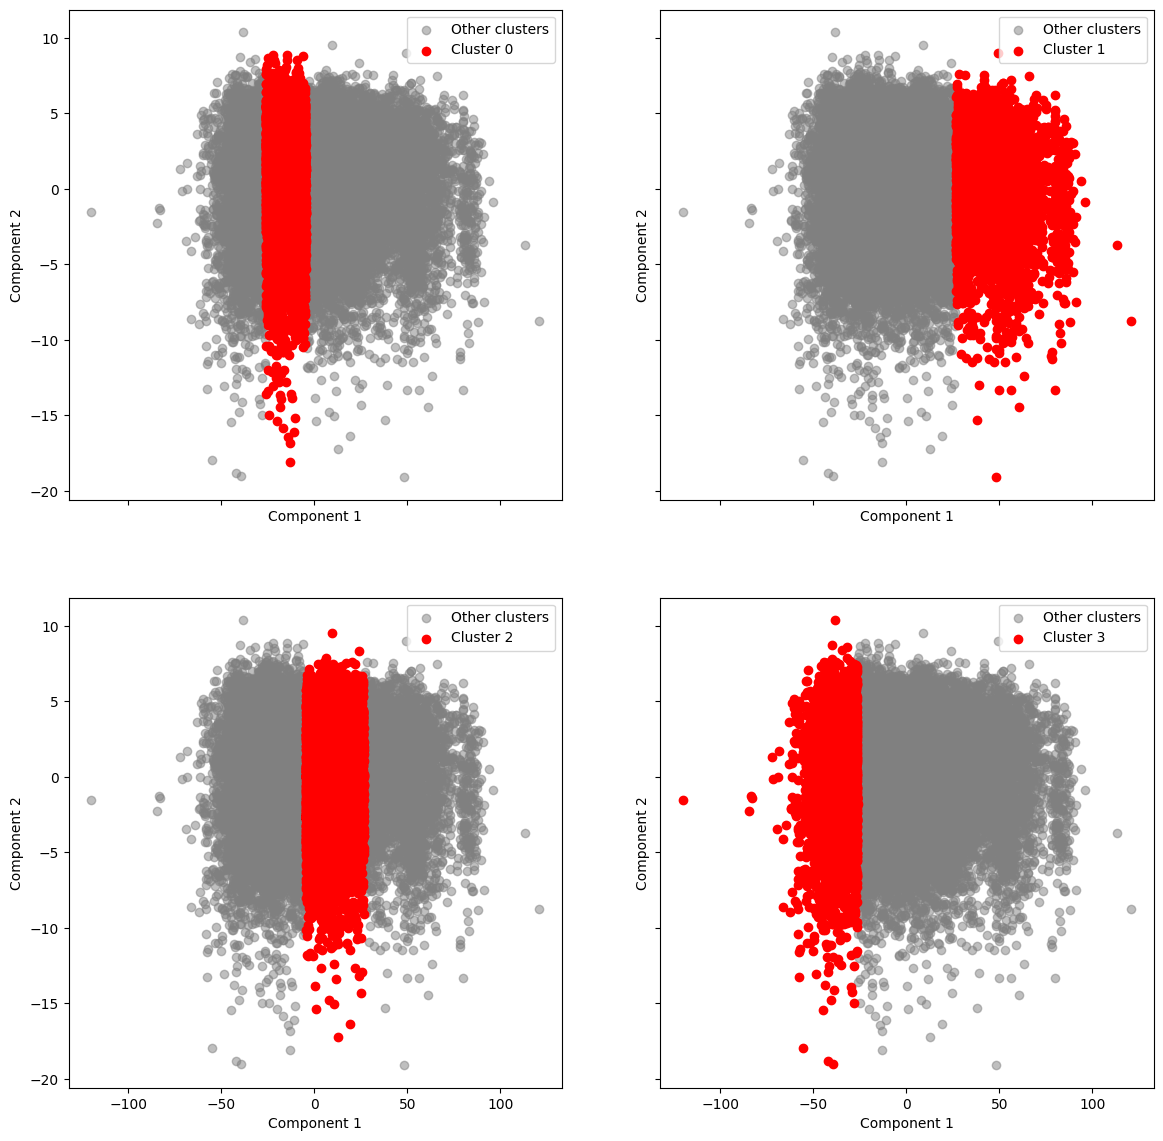

In [18]:
# Get the unique cluster assignments
unique_clusters = np.unique(clusters)

# Create a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,14), sharex=True, sharey=True)

# Flatten the array of subplots to make it easier to iterate over
axs = axs.flatten()

# Iterate over the clusters
for i, cluster in enumerate(unique_clusters):
    # Select the data points belonging to the current cluster
    df_cluster = df_2d[clusters == cluster]

    # Select the data points belonging to other clusters
    df_other_clusters = df_2d[clusters != cluster]

    # Plot the data points belonging to other clusters in gray
    axs[i].scatter(df_other_clusters[:, 0], df_other_clusters[:, 1], c='gray', label='Other clusters', alpha=0.5)

    # Plot the data points belonging to the current cluster with a different color
    axs[i].scatter(df_cluster[:, 0], df_cluster[:, 1], c='red', label='Cluster {}'.format(cluster))

    # Set the x and y labels for the current subplot
    axs[i].set_xlabel('Component 1')
    axs[i].set_ylabel('Component 2')

    # Add a legend to the current subplot
    axs[i].legend()

plt.show()

### Now we look for the characteristics of the **single cluster**

In [19]:
four_cluster_df=cluster_df.copy()
four_cluster_df['cluster']=clusters

In [20]:
# now we can explore the characteristics of the individual cluster
cluster_mean=four_cluster_df.groupby('cluster').mean()
print(cluster_mean)

         danceability    energy       key  loudness      mode  speechiness  \
cluster                                                                      
0           -3.545223 -2.693601  3.725876 -6.291301 -1.052849    -0.872705   
1           -3.681439 -2.655384  3.547085 -5.444438 -1.006683    -0.843655   
2           -3.572081 -2.674871  3.654935 -6.148418 -1.030830    -0.874516   
3           -3.636123 -2.767973  3.667434 -6.596958 -1.012822    -0.858928   

         acousticness  instrumentalness  liveness   valence  time_signature  \
cluster                                                                       
0           -0.847027         -0.238015 -1.115931 -2.093258       -9.158671   
1           -0.858355         -0.242328 -1.103167 -2.116933       -9.194109   
2           -0.850864         -0.231576 -1.106281 -2.089352       -9.135491   
3           -0.749084         -0.245499 -1.107344 -2.189711       -9.175197   

              tempo  spotify_track_duration_minute  
clu

In [21]:
#we drop tempo in the main graph since is out of scale with respect to the other variable 
cluster_mean_wo_tempo=cluster_mean.drop('tempo', axis=1)
#cluster_mean_only_tempo=cluster_mean['tempo']

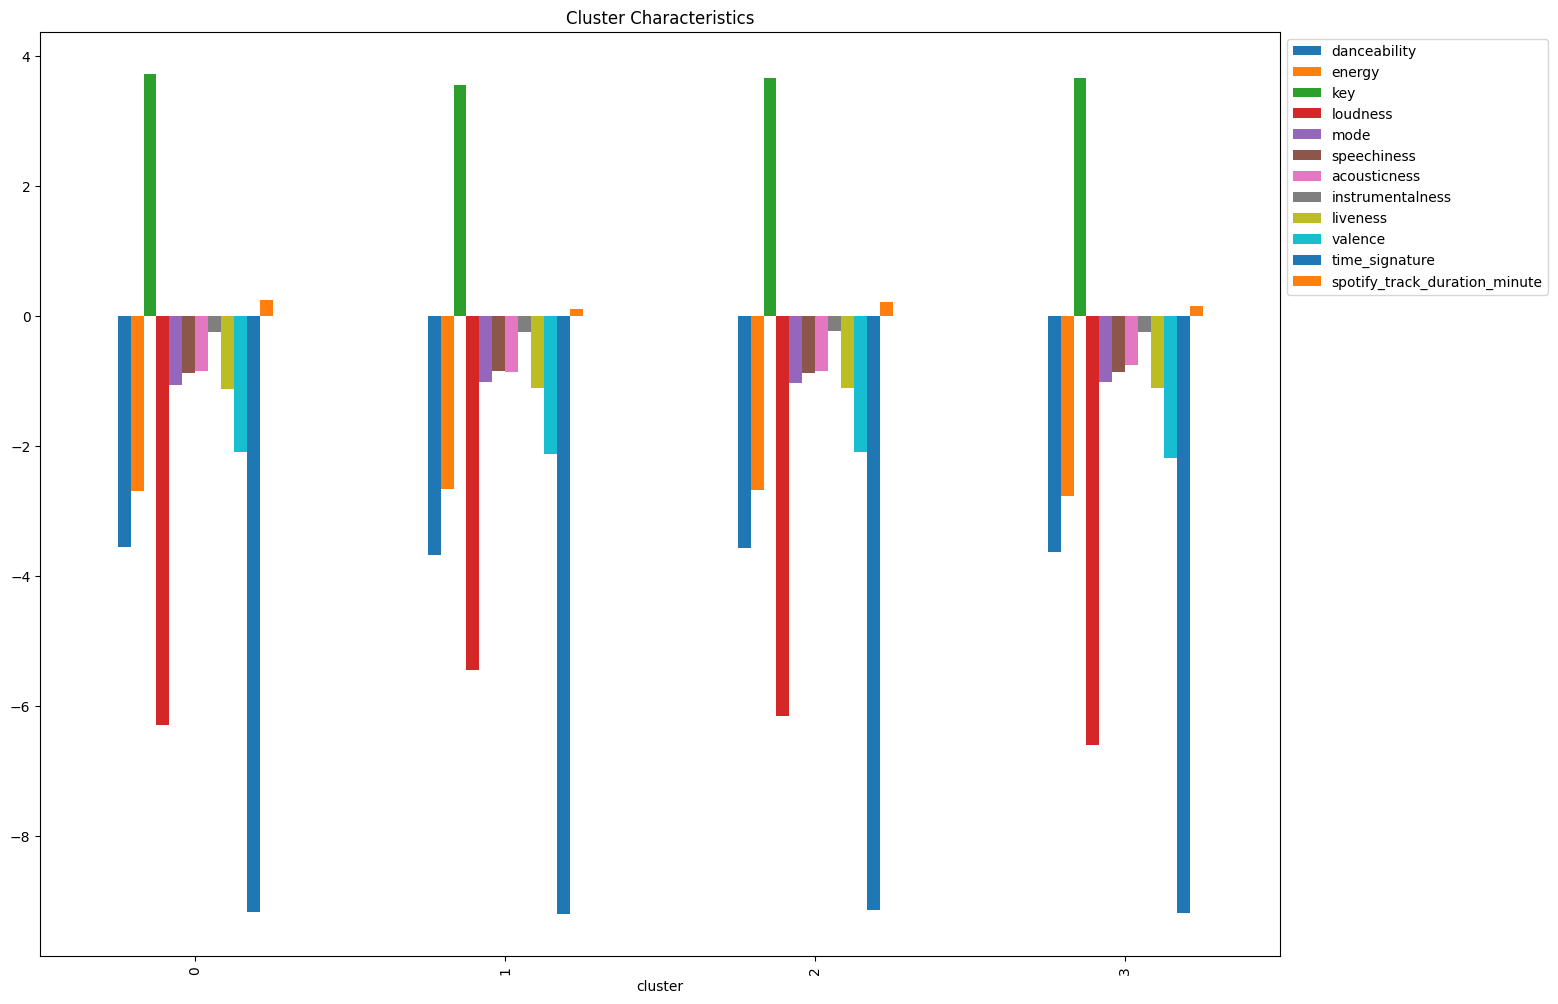

In [22]:
#we build a plot
cluster_mean_wo_tempo.plot(kind='bar',figsize=(16,12))
plt.title('Cluster Characteristics')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

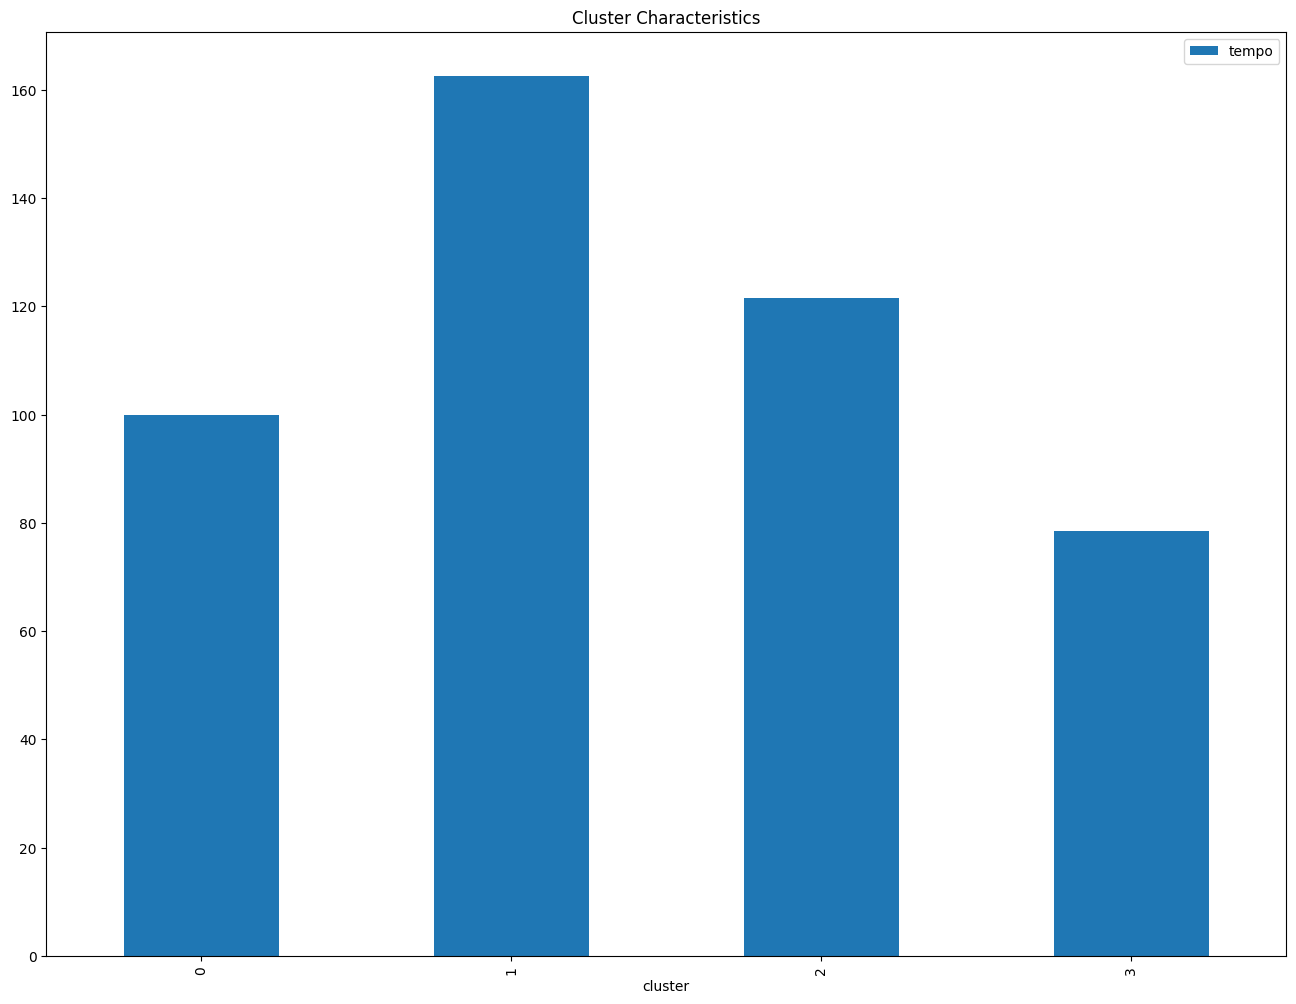

In [23]:
# now we plot tempo 
cluster_mean['tempo'].plot(kind='bar',figsize=(16,12))
plt.title('Cluster Characteristics')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

## This could be usefull for our pourpose

### we find the frequences of the songs that belongs to each cluster

In [24]:
etichette=kmeans.labels_
etichette

array([2, 2, 3, ..., 2, 3, 0], dtype=int32)

In [25]:
cluster1=top17_genere_df[etichette==0]
c1_n_songs_maingenere=cluster1.maingenere.value_counts()
cluster2=top17_genere_df[etichette==1]
c2_n_songs_maingenere=cluster2.maingenere.value_counts()
cluster3=top17_genere_df[etichette==2]
c3_n_songs_maingenere=cluster3.maingenere.value_counts()
cluster4=top17_genere_df[etichette==3]
c4_n_songs_maingenere=cluster4.maingenere.value_counts()

In [26]:
# we create a df with the info that we obtained (songs for cluster, divided by genre)
c1234_df=pd.concat([c1_n_songs_maingenere,c2_n_songs_maingenere,c3_n_songs_maingenere,c4_n_songs_maingenere],axis=1)
c1234_df.columns=['c1','c2','c3','c4']
c1234_df

,c1,c2,c3,c4
maingenere,,,,
pop,1859,1051,3365,1315
rock,1216,778,2541,621
other,794,329,2528,516
soul,690,299,1066,444
rap,496,484,796,483
country,479,486,838,415
disco,216,32,308,46
dance,108,32,179,28
jazz,108,42,178,76


In [27]:
### we want to visualize it
fig1 = px.bar(c1234_df, x=c1234_df.index, y=['c1','c2','c3','c4'], barmode='group',text_auto=True)

fig1.update_layout(title=dict(text="Distribution of genre for each cluster", font=dict(size=50), automargin=True, yref='paper'))

fig1.show()

In [28]:
plt.figure(figsize=(12,8))
fig0 = px.pie(c1234_df, values="c1", names=c1234_df.index,hole=0.5,width =800,height=700)
fig0.update_layout(title_text="Distribution of genre for cluster 1")
fig0.update_traces(textinfo='value+label+percent')
fig0.show()

<Figure size 1200x800 with 0 Axes>

In [29]:
plt.figure(figsize=(12,8))
fig0 = px.pie(c1234_df, values="c2", names=c1234_df.index,hole=0.5,width =800,height=700)
fig0.update_layout(title_text="Distribution of genre for cluster 2")
fig0.update_traces(textinfo='value+label+percent')
fig0.show()

<Figure size 1200x800 with 0 Axes>

In [30]:
plt.figure(figsize=(12,8))
fig0 = px.pie(c1234_df, values="c3", names=c1234_df.index,hole=0.5,width =800,height=700)
fig0.update_layout(title_text="Distribution of genre for cluster 3")
fig0.update_traces(textinfo='value+label+percent')
fig0.show()

<Figure size 1200x800 with 0 Axes>

In [31]:
plt.figure(figsize=(12,8))
fig0 = px.pie(c1234_df, values="c4", names=c1234_df.index,hole=0.5,width =800,height=700)
fig0.update_layout(title_text="Distribution of genre for cluster 4")
fig0.update_traces(textinfo='value+label+percent')
fig0.show()

<Figure size 1200x800 with 0 Axes>